In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

#EBTEL Heating Sandbox

Here, I'm testing whether specifying the range of my power-law distribution allows me to properly constrain the time-averaged heating rate $H_n$.

In [79]:
#specify constants
tau = 100.0
loop_length = 20.0e+8
area = 1.0e+14
tpeak = 4.0e+6
total_time = 8.0e+4
delta = 10.0
const = {'tau':tau,'loop_length':loop_length,'area':area,'tpeak':tpeak,'total_time':total_time,'delta':delta}
#additional parameters
alpha = -1.5
t_wait = np.arange(250,5250,250)

In [80]:
#some functions
def pl_dist(a0,a1,alpha,x):
    return ((a1**(alpha+1) - a0**(alpha+1))*x + a0**(alpha+1))**(1/(alpha+1))
def time_averaged_heating_rate(L,tpeak):
    kappa = 1.0e-6
    return kappa*tpeak**(3.5)/L**2
def mean_energy(const,tn):
    hn = time_averaged_heating_rate(const['loop_length'],const['tpeak'])
    return 2.0*hn*const['loop_length']*const['area']*(const['tau'] + tn)
def min_energy(qmean,delta):
    return qmean*2.0/(delta-1.0) 

Now, for each value of $T_n$, construct a distribution whose bounds are specified such that $H_n$ is constant across $T_n$ and specified such that enough energy is being dumped in to maintain a peak temperature $T_{\mathrm{peak}}$.

In [81]:
wait_time_distributions = []
for tw in t_wait:
    #calculate number of events
    n = int(np.ceil(const['total_time']/(const['tau'] + tw)))
    #calculate bounds
    a0 = min_energy(mean_energy(const,tw),const['delta'])/(const['loop_length']*const['area']*const['tau'])
    a1 = a0*const['delta']
    #calculate the distribution
    wait_time_distributions.append(pl_dist(a0,a1,alpha,np.random.rand(n)))

Let's check what the time-averaged heating rate should be for our specified conditions in order to keep our plasma at an equilibrium temperature of $T_{\mathrm{peak}}$ and then plot the resulting values for our distributions constructed according to our constraint on $Q_{\mathrm{min}}$.

In [90]:
hn_target = time_averaged_heating_rate(const['loop_length'],const['tpeak'])
print "The time-averaged heating rate for L=%.1f Mm and T_peak=%.1f MK is %.5f"%(const['loop_length']/1.0e+8,const['tpeak']/1.0e+6,hn_target)

The time-averaged heating rate for L=20.0 Mm and T_peak=4.0 MK is 0.03200


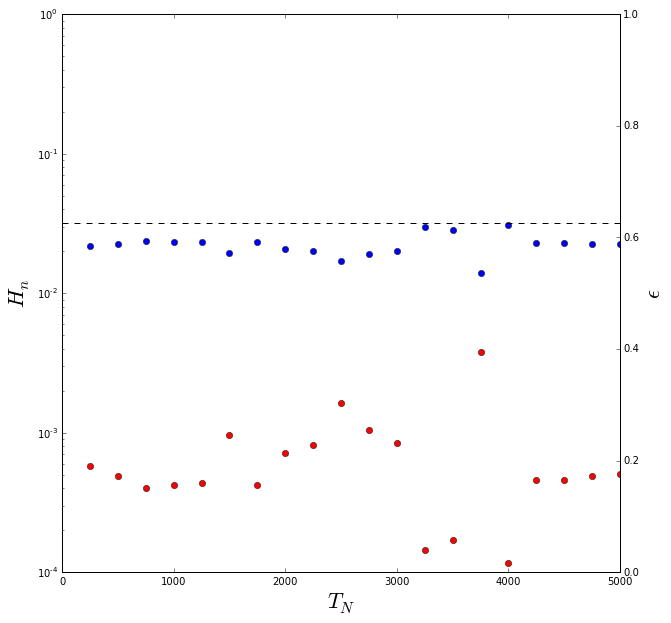

In [91]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
error_axis = ax.twinx()
for i in range(len(t_wait)):
    hn_tw = const['tau']/2.0*np.sum(wait_time_distributions[i])/const['total_time']
    ax.plot(t_wait[i],hn_tw,'bo')
    error_axis.plot(t_wait[i],np.fabs(hn_tw - hn_target)/np.fabs(hn_tw + hn_target),'ro')
ax.axhline(y=time_averaged_heating_rate(const['loop_length'],const['tpeak']),color='k',linestyle='--')
ax.set_xlabel(r'$T_N$',fontsize=22)
ax.set_ylabel(r'$H_n$',fontsize=22)
error_axis.set_ylabel(r'$\epsilon$',fontsize=22)
ax.set_ylim([0.0001,1.0])
error_axis.set_ylim([0,1])
ax.set_yscale('log')
plt.show()

Let's compare this to the case where we dont' attempt to constrain the heating at all.

In [84]:
wait_time_distributions_no_constraint= []
for tw in t_wait:
    #calculate number of events
    n = int(np.ceil(const['total_time']/(const['tau'] + tw)))
    #calculate bounds
    a0 = 1.0e+23/(const['loop_length']*const['area']*const['tau'])
    a1 = a0*const['delta']
    #calculate the distribution
    wait_time_distributions_no_constraint.append(pl_dist(a0,a1,alpha,np.random.rand(n)))

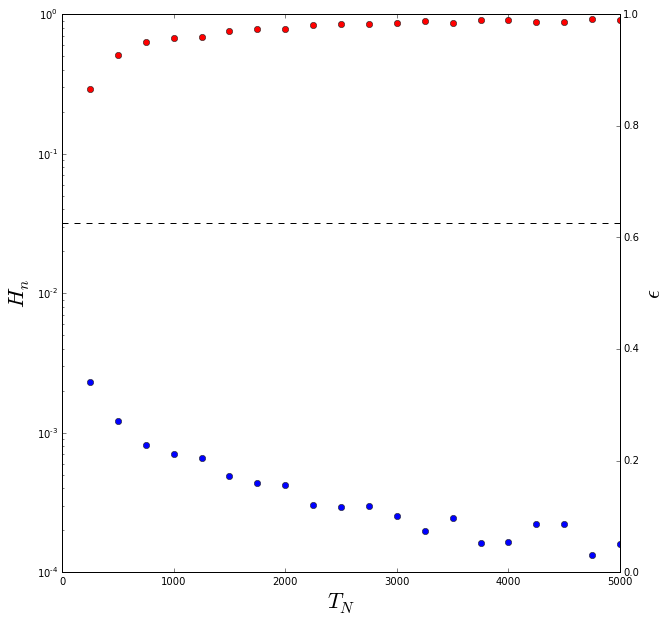

In [89]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
error_axis = ax.twinx()
for i in range(len(t_wait)):
    hn_tw = const['tau']/2.0*np.sum(wait_time_distributions_no_constraint[i])/const['total_time']
    ax.plot(t_wait[i],hn_tw,'bo')
    error_axis.plot(t_wait[i],np.fabs(hn_tw - hn_target)/np.fabs(hn_tw + hn_target),'ro')
ax.axhline(y=hn_target,color='k',linestyle='--')
ax.set_xlabel(r'$T_N$',fontsize=22)
ax.set_ylabel(r'$H_n$',fontsize=22)
error_axis.set_ylabel(r'$\epsilon$',fontsize=22)
ax.set_ylim([0.0001,1.0])
error_axis.set_ylim([0,1])
ax.set_yscale('log')
plt.show()

Obviously, the case where we attempt to constrain the range of our distribution yields much better results in terms of consistency across our range of $T_N$ values as well as matching our target $H_n$ value as compared to our current method which makes no attempt to maintain constant time-averaged heating rate. However, even in the case of varying $Q_{\mathrm{min}}$, we can see that we are still off target by a factor of 2-3 in some cases. This is most likely due to our poor estimate of $Q_{\mathrm{min}}$.

##Improved Estimates of $Q_{\mathrm{min}}$

Recall that we can calculate the mean of our power-law distribution even for $\alpha\le2$ using a Monte-Carlo approach provided we specify the bounds $a,b$. Thus, we want to find $a$ (with $b=\delta a$) such that $$\langle Q\rangle - \frac{a(\delta - 1)}{\mathcal{N}}\sum_{i=1}^{\mathcal{N}}x_ip(x_i)=0$$where $\langle Q\rangle$ is the mean energy per nanoflare as specified by $H_n$ and $T_N$, $\mathcal{N}$ is the number of points uniformly distributed on $x_i\in[a,\delta a]$, and $p(x)$ is our power-law relation. 

By coming up with a value $a$ which satisfies this relation, we will have an improved calculation of $Q_{\mathrm{min}}$ and thus better constrain $H_i$ such that the $H_n=\tau/2\sum_{i=1}^NH_i/T_{\mathrm{total}}$.

In [92]:
#monte-carlo integrator function
def monte_carlo_integrator(N,f,**kwargs):
    #generate points in the given range
    np.random.seed()
    points = (kwargs['b'] - kwargs['a'])*np.random.rand(N) + kwargs['a']
    
    #calculate the average
    f_sum = 0.0
    for p in points:
        f_sum = f_sum + f(p,**kwargs)
    f_mean = f_sum/N
    
    #return total answer
    return (kwargs['b'] - kwargs['a'])*f_mean
#power-law mean function
def pl_mean(x,**kwargs):
    #define coefficient
    C = (1.0 - kwargs['alpha'])/(kwargs['b']**(1.0-kwargs['alpha']) - kwargs['a']**(1.0-kwargs['alpha']))
    #define power-law function
    f = C*x**(-kwargs['alpha'])
    #return the mean integrand
    return x*f

Define the function that we are trying to find the zero of.

In [94]:
#function to which we will apply bisection or root finder method
def f_zero(a,**kwargs):
    #define dictionary
    const = kwargs['const']
    #get target mean value
    q_mean = mean_energy(const,kwargs['tn'])
    #set up monte-carlo function
    mc_mean = monte_carlo_integrator(kwargs['n_mc'],pl_mean,a=a,b=const['delta']*a,alpha=kwargs['alpha'])
    return q_mean - mc_mean

Now, define the bisection method.

In [95]:
def bisection(a,b,f,options,**kwargs):
    """Bisection method for interval (a,b) as applied to a monotonically increasing (or decreasing) function f on (a,b)"""
    
    #First guess for root value
    c = a + (b - a)/2
    
    #Evaluate function at first guess
    f_guess = f(c,**kwargs)
    
    #Initialize the counter
    count = 0
    
    #Initialize lists of endpoints and roots
    a_list = [a]
    b_list = [b]
    c_list = [c]
    
    #Begin iteration
    while(count<options['max_count'] and np.fabs(f_guess)>options['tol']):
        #Output iteration and endpoints
        print "Iteration %d, Endpoints (%f,%f)"%(count,a,b)
        
        #Check relative sign
        if f_guess*f(a,**kwargs)>0:
            #advance left endpoint
            a=c
        elif f_guess*f(a,**kwargs)<0:
            #advance right endpoint
            b=c
        else:
            #case where f(c)==0
            print "f(c) == 0 exactly. Breaking out of loop."
            break
            
        #update root value guess
        c = a + (b-a)/2
        
        #evaluate function at current guess
        f_guess = f(c,**kwargs)
        
        #save a,b,c values
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)
        
        #update the counter
        count = count + 1
        
    #check to see whether we succeded
    if count < options['max_count'] or np.fabs(f_guess) < options['tol']:
        #print final zero approximation
        print "Value of the function at approximate zero is f(c=%f)=%f"%(c,f_guess)
    
        #return lists of a,b,c
        return a_list,b_list,c_list
    else:
        #tell the user that the bisection failed
        print "Unable to perform bisection with max number of tries = %d and error tolerance %.4f"%(options['max_count'],options['tol'])

To make an estimation of our bounds for the bisection method, 